# Cortical network model simulations for hFUS paper

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports
import os
import time
import numpy as np 
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Internal imports
from network import SimplifiedCorticalNetwork
from logger import logger
from utils import *

# Record notebook start time
t0 = time.perf_counter()

# Set up figures directory and initialize figures dictionary
figs_dir = 'figures/'
figs = {}

### Input parameters

In [11]:
# Drive parameters
noise_amp = 2e-3  # noise amplitude (mA/cm2)

# Stimulus parameters
start = 50 # start time (ms)
dur = 150  # duration (ms)
Pmax = 3.0  # maximum pressure amplitude (MPa)
Prange = np.linspace(0, Pmax, 15)  # range of pressure amplitudes to sweep
Prange_dense = np.linspace(0, Pmax, 30)  # dense range of pressure amplitudes to sweep

# Simulation parameters
tstop = 350  # default simulation duration (ms)
nreps = 50  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'noise': [
        f'amplitude = {noise_amp:.3f} mA/cm2'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'range of pressure amplitudes = {Prange[0]:.2f} - {Prange[-1]:.2f} MPa'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 31/10/2024 00:05:23: Input parameters:
   - noise:
       - amplitude = 0.002 mA/cm2
   - stimulus:
       - start = 50 ms
       - duration = 150 ms
       - range of pressure amplitudes = 0.00 - 3.00 MPa
   - simulation:
       - duration = 350 ms
       - number of repetitions (for sweeps) = 50


### Initialize single-node model

In [4]:
# Initialize single-node model with temperature-dependent components
nnodes = 1
model = SimplifiedCorticalNetwork(
    nnodes,
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=SimplifiedCorticalNetwork.gKT_default,  # S/cm2
    a=5.6e-4,  # mA/cm2/MPa 
    synweight=90e-6, # synaptic weight (S/cm2)
)

# Set stimulus start and duration
model.start = start
model.dur = dur

# Set simulation duration
model.tstop = tstop

 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): created 1 node
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): setting Q10_rates = 3 on node 0
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): setting Q10_gNa = 1.4 on node 0
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): setting Q10_gKd = 4.75 on node 0
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): setting gKT = 4.898648648648648e-06 on node 0
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): setting a = 0.00056 on node 0
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): initialized


### Run detailed simulations in sub-threshold, threshold and supra-threshold regimes, with noise

 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): finding response thresold pressure amplitude within [0, 5.0] MPa interval
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): setting 150.00 ms stimulus with amplitude 0.93 MPa on 100.0% of nodes
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): simulating for 350.00 ms
 30/10/2024 22:15:09: Spiking threshold: 0.93 MPa <-> 0.52 uA/cm2
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): setting 150.00 ms stimulus with amplitude 0.84 MPa on 100.0% of nodes
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): noise current injection requires fixed time step -> setting dt = 0.025 ms
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): simulating for 350.00 ms
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): setting 150.00 ms stimulus with amplitude 1.03 MPa on 100.0% of nodes
 30/10/2024 22:15:09: SimplifiedCorticalNetwork(1): simulating for 350.00 ms
 30/10/2024 22:15:10: SimplifiedCorticalNetwork(1): setting 150.00 ms stimulus with a

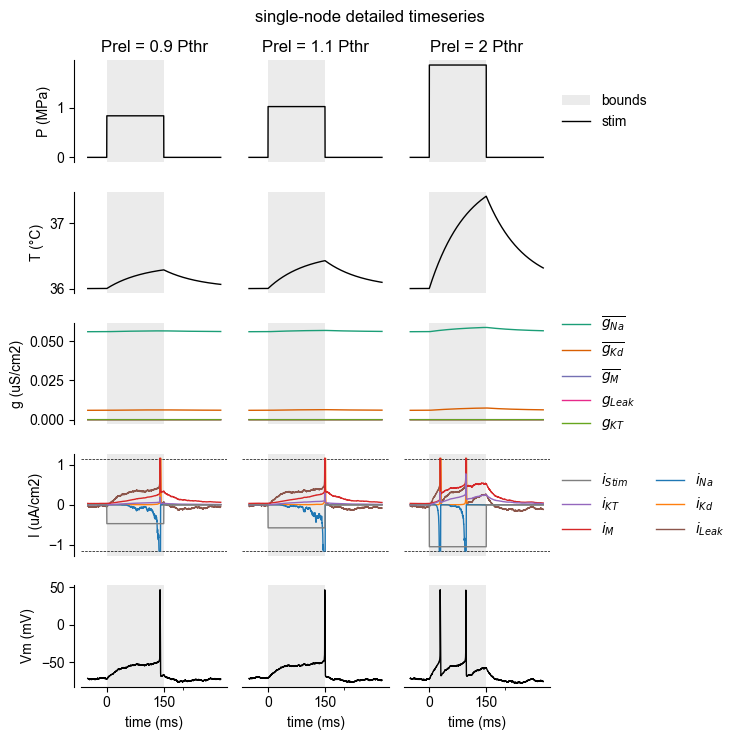

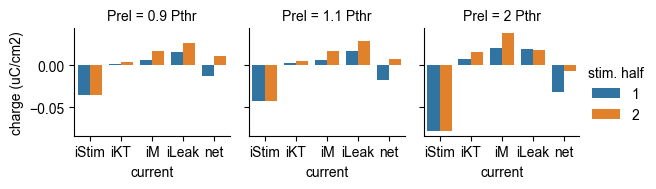

In [5]:
# Find spiking threshold (without stochastic noise) and corresponding current amplitude
model.noise_amp = 0
Pthr = model.find_spiking_threshold()
model.set_stim(Pthr)
data = model.simulate()
iStimthr = data['iStim'].abs().max()
logger.info(f'Spiking threshold: {Pthr:.2f} MPa <-> {iStimthr * 1e3:.2f} uA/cm2')
model.noise_amp = noise_amp  # mA/cm2

# Set sub- and supra-threshold amplitudes
rel_Pamps = [0.9, 1.1, 2]

# Plot simulation results at various sub, threshold and supra-threshold amplitudes
data = {}
for rel_Pamp in rel_Pamps:
    Pamp = rel_Pamp * Pthr
    model.set_stim(Pamp)
    data[f'{rel_Pamp} Pthr'] = model.simulate()
data = pd.concat(data, axis=0, names=['Prel'])

title = f'single-node detailed timeseries'
figs[title] = model.plot_results(
    data, 
    exclude=[
        # 'T',
        # 'conductances', 
    ], 
    clip_currents=True,
    gmode='abs',
)
figs[title].suptitle(title)

# Compare injected charges by each current in first and second half of stimulus
charges = model.compute_charge_by_stimhalf(data).drop(['iNa', 'iKd'], axis=1)
charges['net'] = charges.sum(axis=1)
qkey = 'charge (uC/cm2)'
g = sns.catplot(
    height=2,
    data=charges.stack().rename(qkey).reset_index(),
    kind='bar',
    x='current',
    y=qkey,
    hue='stim. half',
    col='Prel',
)
figs['single node charge'] = g.figure

### Extend to 3-nodes

 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): created 3 nodes


 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): setting Q10_rates = 3 on all nodes
 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): setting Q10_gNa = 1.4 on all nodes
 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): setting Q10_gKd = 4.75 on all nodes
 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): setting a = 0.00056 on all nodes
 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): initialized
 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): connecting 100.0% (6/6) of candidate node pairs
 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): setting 150.00 ms stimulus with amplitude 1.03 MPa on 33.3% of nodes
 30/10/2024 22:15:13: SimplifiedCorticalNetwork(3): simulating for 350.00 ms
 30/10/2024 22:15:14: SimplifiedCorticalNetwork(3): plotting results
 30/10/2024 22:15:14: SimplifiedCorticalNetwork(3): setting 150.00 ms stimulus with amplitude 1.03 MPa on 100.0% of nodes

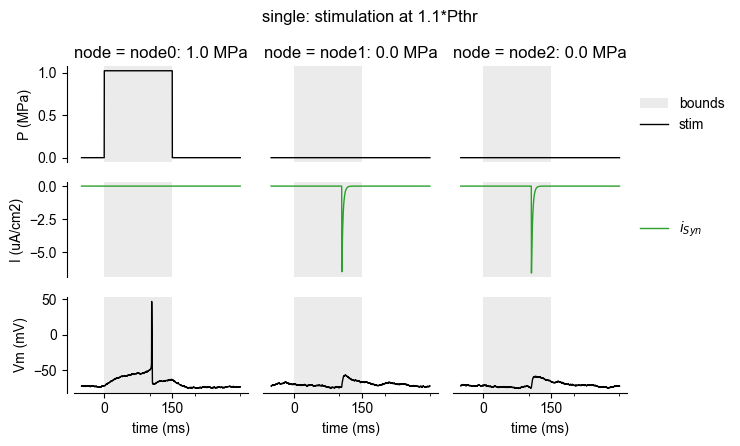

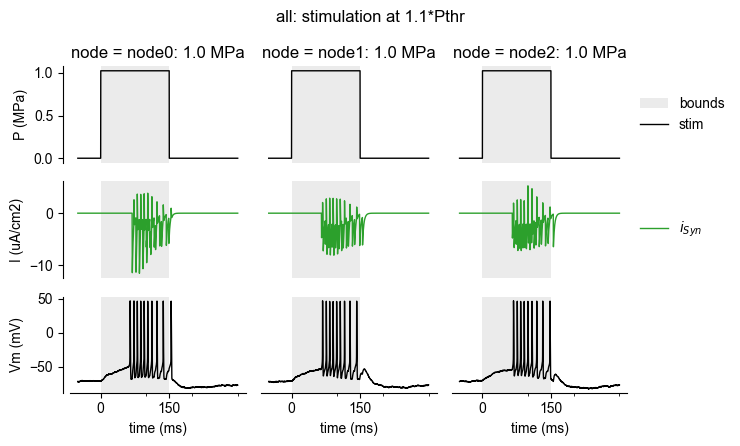

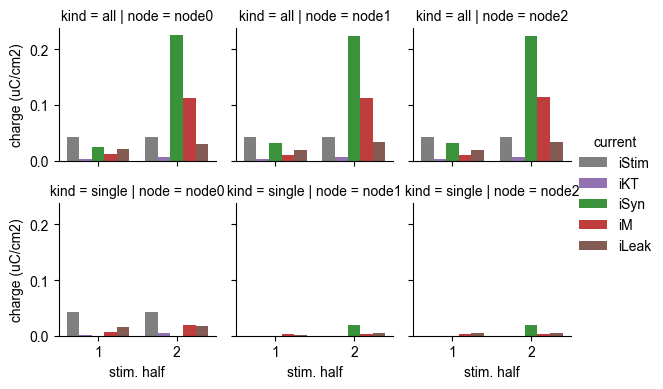

In [6]:
# Create 3-nodes network
model3 = model.copy(nnodes=3)
model3.connect_nodes(weight=90e-6)  # synaptic weight (S/cm2))

# Plot simulation results at various sub, threshold and supra-threshold amplitudes 
datacomp = {}
for kind, xvec in model3.get_stimdists().items():
    Prel = 1.1
    Pamp = Prel * Pthr
    model3.set_stim(Pamp * xvec)
    data = model3.simulate()
    title = f'{kind}: stimulation at {Prel}*Pthr'
    figs[title] = model3.plot_results(
        data, 
        exclude=[
            'T',
            'conductances',
            'iNa', 'iKd', 'iLeak', 'iM', 'iKT', 'iStim'
        ],
        # clip_currents=True, 
    )
    figs[title].suptitle(title)
    datacomp[kind] = data

# Compare injected charges by each current in first and second half of stimulus
datacomp = pd.concat(datacomp, axis=0, names=['kind'])
charges = model3.compute_charge_by_stimhalf(datacomp).drop(['iNa', 'iKd'], axis=1)
g = sns.catplot(
    data=charges.abs().stack().rename(qkey).reset_index(),
    kind='bar',
    x='stim. half',
    hue='current',
    y=qkey,
    col='node',
    row='kind',
    height=2,
    palette=model.CURRENTS_CMAP
)
figs['3nodes charge comp'] = g.figure

### Evoked activity across stimulus amplitude/intensity range

 31/10/2024 00:05:33: SimplifiedCorticalNetwork(3): running simulation sweep across 30 stimulus amplitudes


100%|██████████| 30/30 [06:21<00:00, 12.70s/it]


 31/10/2024 00:15:00: SimplifiedCorticalNetwork(3): running simulation sweep across 30 stimulus amplitudes


100%|██████████| 30/30 [06:27<00:00, 12.92s/it]


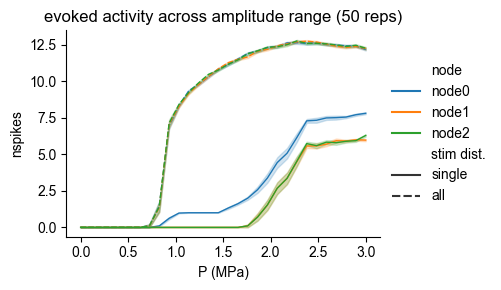

In [12]:
# Run comparative simulations across Isppa range and extract spike counts
nspikes = model3.run_comparative_sweep(
    Prange_dense, 
    'nspikes',
    nreps=nreps,
)

# Plot spike count across Isppa range for each stim dist
figs['nspikes_vs_pressure'], ax = plt.subplots(figsize=(5, 3))
ax.set_title(f'evoked activity across amplitude range ({nreps} reps)', fontsize=12)
model.plot_sweep_results(
    nspikes, 
    ax=ax, 
    legend=True, 
    marker=None, 
)
# Adjust figure layout
figs['nspikes_vs_pressure'].tight_layout()

## Save figures

In [13]:
# Check that figures directory exists
figsdir = os.path.abspath(figs_dir)
if not os.path.isdir(figsdir):
    raise ValueError(f'Figures directory "{figsdir}" does not exist')

# Save figures in directory
save_figs_book(figsdir, figs)

 31/10/2024 00:25:06: saving figures in /Users/tlemaire/Documents/code/fusnetwork/figures/2024.10.31/figs.pdf:


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


## Log completion

In [9]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 30/10/2024 22:15:52: notebook completed in 0:00:43.201392
